# EfficientNet & EfficientNetV2 - Finetuning
This notebook was used to finetune EfficientNet & EfficientNetV2 models for the ASL fingerspelling task.

## Setup
In this section all the necessary libraries are imported.

In [3]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


And the necessary imports are executed.

In [4]:
import torch.nn as nn
import torchvision.models as visionmodels

import os

# Our own modules
import models.sweep_helper as sweep_helper


from models.asl_model import ASLModel
from models.training import sweep, train_model

In [5]:
from datapipeline.asl_image_data_module import ASLImageDataModule, DEFAULT_TRANSFORMS

INFO:fiftyone.zoo.datasets:Downloading split 'train' to 'C:\Users\kybur\fiftyone\open-images-v7\train' if necessary


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'train' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'train' is sufficient


Loading existing dataset 'open-images-v7-train-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'open-images-v7-train-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to 'C:\Users\kybur\fiftyone\open-images-v7\validation' if necessary


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'validation' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'validation' is sufficient


Loading existing dataset 'open-images-v7-validation-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'open-images-v7-validation-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Downloading split 'test' to 'C:\Users\kybur\fiftyone\open-images-v7\test' if necessary


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'test' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'test' is sufficient


Loading existing dataset 'open-images-v7-test-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'open-images-v7-test-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Downloading split 'train' to 'C:\Users\kybur\fiftyone\open-images-v7\train' if necessary


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'train' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'train' is sufficient


Loading existing dataset 'open-images-v7-train-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'open-images-v7-train-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to 'C:\Users\kybur\fiftyone\open-images-v7\validation' if necessary


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'validation' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'validation' is sufficient


Loading existing dataset 'open-images-v7-validation-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'open-images-v7-validation-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Downloading split 'test' to 'C:\Users\kybur\fiftyone\open-images-v7\test' if necessary


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'test' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'test' is sufficient


Loading existing dataset 'open-images-v7-test-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'open-images-v7-test-1000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
c:\Users\kybur\Repos\HSLU\dspro2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing
No general data preprocessing is necessary, however there will be random transforms applied to the images during training according to the transforms that are passed to the data module.

In [6]:
PATH = "/exchange/dspro2/silent-speech/ASL_Pictures_Dataset"

In [7]:
datamodule = ASLImageDataModule(path=PATH, train_transforms=DEFAULT_TRANSFORMS.TRAIN, valid_transforms=DEFAULT_TRANSFORMS.VALID, test_transforms=DEFAULT_TRANSFORMS.TEST, val_split_folder="Validation", batch_size=32, num_workers=128)

## Model
This section defines the model architecture, based on the ResNet model.

In [8]:
NUM_CLASSES = 28

In [9]:
class ASLEfficientNet(nn.Module):
    def __init__(self, efficientnet_model: visionmodels.efficientnet.EfficientNet, dropout: float = 0.2, unfreeze_features: int = 1, num_classes: int = NUM_CLASSES):
        super().__init__()
        self.model = efficientnet_model
        self.model.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.model.classifier[1].in_features, num_classes)
        )

        unfreeze_features = min(unfreeze_features, len(self.model.features))
        self.unfreeze_features = unfreeze_features
        self.model.features[:len(self.model.features)-unfreeze_features].requires_grad_(False)

    def forward(self, x):
        return self.model(x)

    def get_main_params(self):
        yield from self.model.classifier.parameters()

    def get_finetune_params(self):
        yield from self.model.features.parameters()

## Training
This section contains the training of the model. First by defining several methods that will be used in the effective training procedure later on. This section is setup to be run multiple times for different experiments.

In [10]:
EFFICIENTNET_MODEL = "efficientnet_model"
DROPOUT = "dropout"

The following cell loads a pretrained EfficientNet model, given a model name; we ended up using B0 and V2-S only.

In [11]:
def get_pretrained_efficientnet_model(model_type: str):
    if model_type == "b0":
        efficientnet_model = visionmodels.efficientnet_b0(weights=visionmodels.EfficientNet_B0_Weights.DEFAULT)
    elif model_type == "b1":
        efficientnet_model = visionmodels.efficientnet_b1(weights=visionmodels.EfficientNet_B1_Weights.DEFAULT)
    elif model_type == "b2":
        efficientnet_model = visionmodels.efficientnet_b2(weights=visionmodels.EfficientNet_B2_Weights.DEFAULT)
    elif model_type == "b3":
        efficientnet_model = visionmodels.efficientnet_b3(weights=visionmodels.EfficientNet_B3_Weights.DEFAULT)
    elif model_type == "b4":
        efficientnet_model = visionmodels.efficientnet_b4(weights=visionmodels.EfficientNet_B4_Weights.DEFAULT)
    elif model_type == "b5":
        efficientnet_model = visionmodels.efficientnet_b5(weights=visionmodels.EfficientNet_B5_Weights.DEFAULT)
    elif model_type == "b6":
        efficientnet_model = visionmodels.efficientnet_b6(weights=visionmodels.EfficientNet_B6_Weights.DEFAULT)
    elif model_type == "b7":
        efficientnet_model = visionmodels.efficientnet_b7(weights=visionmodels.EfficientNet_B7_Weights.DEFAULT)
    elif model_type == "v2-s":
        efficientnet_model = visionmodels.efficientnet_v2_s(weights=visionmodels.EfficientNet_V2_S_Weights.DEFAULT)
    elif model_type == "v2-m":
        efficientnet_model = visionmodels.efficientnet_v2_m(weights=visionmodels.EfficientNet_V2_M_Weights.DEFAULT)
    elif model_type == "v2-l":
        efficientnet_model = visionmodels.efficientnet_v2_l(weights=visionmodels.EfficientNet_V2_L_Weights.DEFAULT)

    return efficientnet_model

This method loads the ASL classification model given a EfficientNet architecture.

In [12]:
UNFREEZE_FEATURES = "unfreeze_features"


def get_asl_efficientnet_model(efficientnet_model: visionmodels.efficientnet.EfficientNet, dropout: float, unfreeze_features: int = 0) -> nn.Module:
    return ASLEfficientNet(efficientnet_model, dropout=dropout, unfreeze_features=unfreeze_features)

The following method creates the model based on config that comes from the Weights & Biases sweep.

In [13]:
def get_efficientnet_model_from_config(config: dict) -> nn.Module:
    efficientnet_model = get_pretrained_efficientnet_model(config[EFFICIENTNET_MODEL])
    model = get_asl_efficientnet_model(efficientnet_model, config[DROPOUT], config[UNFREEZE_FEATURES])
    return model

The following cell specifies the training procedure that will be executed for each run in the Weights & Biases sweep.

In [14]:
SEED = 42


def train_efficient_net():
    train_model("efficientnet", get_efficientnet_model_from_config, datamodule, get_optimizer=sweep_helper.get_optimizer_with_finetune_group, seed=SEED)

The following cell specifies the configuration of the Weights & Biases sweep.

In [15]:
sweep_config = {
    "name": "EfficientNet-V2-S",
    "method": "bayes",
    "metric": {
        "name": f"{ASLModel.VALID_ACCURACY}",
        "goal": "maximize"
    },
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 5
    },
    "parameters": {
        EFFICIENTNET_MODEL: {
            "value": "v2-s"
        },
        UNFREEZE_FEATURES: {
           "value": 1
        },
        DROPOUT: {
            "min": 0.1,
            "max": 0.5
        },
        sweep_helper.OPTIMIZER: {
            "parameters": {
                sweep_helper.TYPE: {
                    "value": sweep_helper.OptimizerType.RMSPROP
                },
                sweep_helper.LEARNING_RATE: {
                    "min": 1e-5,
                    "max": 1e-3,
                    "distribution": "log_uniform_values"
                },
                sweep_helper.FINETUNE_LEARNING_RATE: {
                    "min": 1e-7,
                    "max": 1e-5,
                    "distribution": "log_uniform_values"
                },
                sweep_helper.WEIGHT_DECAY: {
                    "min": 0,
                    "max": 1e-3,
                },
                sweep_helper.MOMENTUM: {
                    "min": 0.8,
                    "max": 0.99
                }
            }
        },
        sweep_helper.LEARNING_RATE_SCHEDULER: {
             "parameters": {
                sweep_helper.TYPE: {
                    "values": [sweep_helper.LearningRateSchedulerType.STEP, sweep_helper.LearningRateSchedulerType.EXPONENTIAL]
                },
                sweep_helper.STEP_SIZE: {"value": 5},
                sweep_helper.GAMMA: {
                    "min": 0.1,
                    "max": 0.9
                }
            }
        }
    }
}

While this cell actually executes the sweep setup in the previous cell.

In [ ]:
sweep(sweep_config=sweep_config, count=20, training_procedure=train_efficient_net)

## Evaluation
This section contains the evaluation of the selected model. It will load the model from the Weights & Biases run and evaluate it on the test set.

In [16]:
from datapipeline.asl_image_test_data_module import ASLImageTestDataModule
from models.evaluation import Evaluation, show_confusion_matrix
from models.training import PROJECT_NAME, ENTITY_NAME

In [17]:
TEST_FOLDER = r"/exchange/dspro2/silent-speech/Test_Images/"

In [18]:
test_datamodule = ASLImageTestDataModule(path=TEST_FOLDER, num_workers=20, batch_size=128)

### EfficientNet B0
This section evalutes the EfficientNet B0 model on the test set.

The next cell prepares the `nn.Module` to which the weights of the checkpoint will be loaded.

In [19]:
architecture = get_asl_efficientnet_model(get_pretrained_efficientnet_model("b0"), 0, 9)

The W&B artifact to load for the evaluation.

In [20]:
artifact = "model-d15nmn0q:v0"

The next cell prepares the evaluation.

In [21]:
evaluation = Evaluation("efficientnet-b0-eval", project=PROJECT_NAME, entity=ENTITY_NAME, model_architecture=architecture, artifact=artifact, datamodule=test_datamodule)

And this cell actually runs the evaluation.

In [80]:
results = evaluation()

wandb:   1 of 1 files downloaded.  
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.4659913182258606
        test_loss           1.9086899757385254
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Predicting: |          | 0/? [00:00<?, ?it/s]

epoch,▁
test_accuracy,▁
test_loss,▁
trainer/global_step,▁
epoch,0
test_accuracy,0.46599
test_loss,1.90869
trainer/global_step,0


Using the outputs of the evaluation, the confusion matrix is plotted.

In [81]:
predictions, targets = results

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix EfficientNet-B0'}, xlabel='Predicted label', ylabel='True label'>)

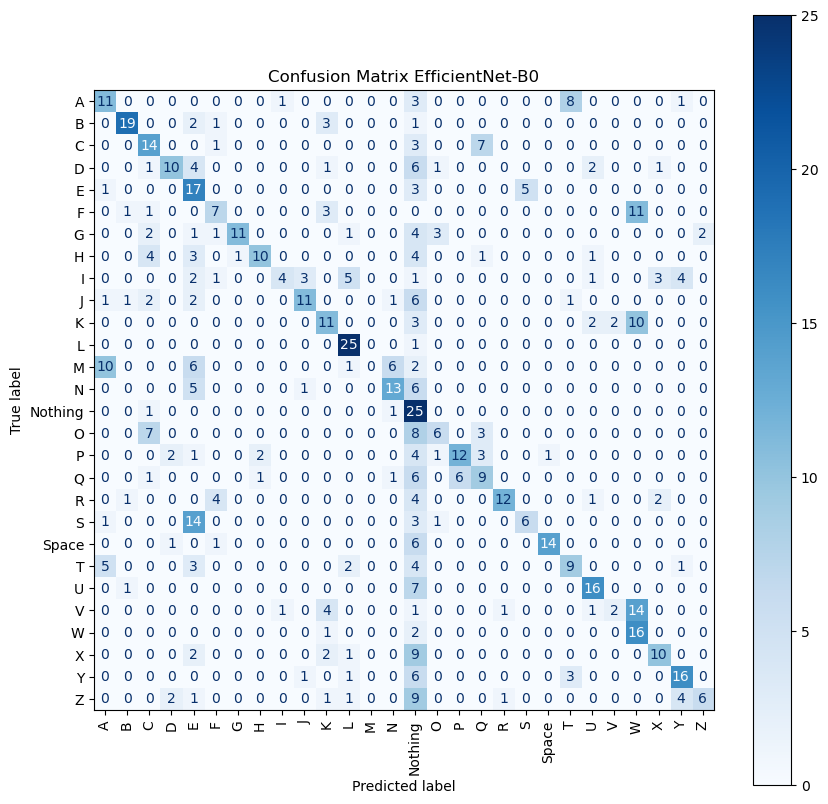

In [82]:
show_confusion_matrix(targets, predictions, title="Confusion Matrix EfficientNet-B0")

### EfficientNetV2-S
This section evalutes the EfficientNetV2-S model on the test set.

The next cell prepares the `nn.Module` to which the weights of the checkpoint will be loaded.

In [22]:
architecture = get_asl_efficientnet_model(get_pretrained_efficientnet_model("v2-s"), 0, 2)

The W&B artifact to load for the evaluation.

In [23]:
artifact = "model-dacnc98s:v2"

The next cell prepares the evaluation.

In [24]:
evaluation = Evaluation("efficientnet-v2-s-eval", project=PROJECT_NAME, entity=ENTITY_NAME, model_architecture=architecture, artifact=artifact, datamodule=test_datamodule)

In [86]:
results = evaluation()

wandb: Downloading large artifact model-dacnc98s:v2, 192.04MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.49782922863960266
        test_loss           2.8274447917938232
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

epoch,▁
test_accuracy,▁
test_loss,▁
trainer/global_step,▁
epoch,0
test_accuracy,0.49783
test_loss,2.82744
trainer/global_step,0


Using the outputs of the evaluation, the confusion matrix is plotted.

In [87]:
predictions, targets = results

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix EfficientNet-V2-S'}, xlabel='Predicted label', ylabel='True label'>)

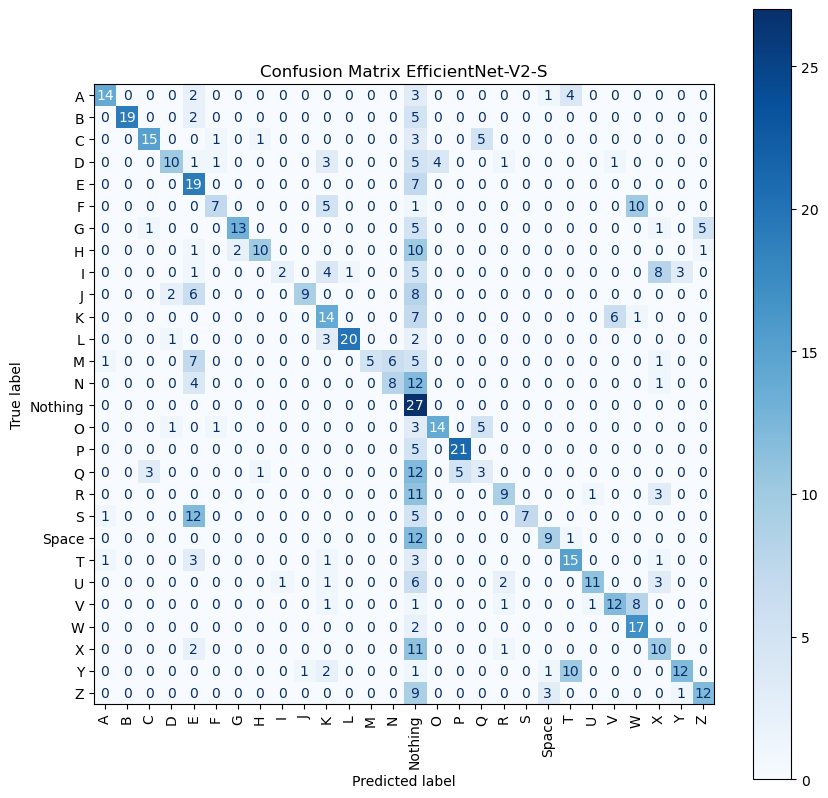

In [88]:
show_confusion_matrix(targets, predictions, title="Confusion Matrix EfficientNet-V2-S")